Referencing a deep learning model from the article below:
https://towardsdatascience.com/energy-consumption-time-series-forecasting-with-python-and-lstm-deep-learning-model-7952e2f9a796

In [61]:
# Load Modules
import numpy as np 
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [62]:
# Set Plotting Styles
plt.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = (18, 18)

In [63]:
# Load Data
comed_df = pd.read_csv('Resources/DataFiles/COMED_hourly.csv', index_col=[0], parse_dates=[0])

# Sort Data
comed_df.sort_index(inplace=True)

# print(comed_df)

In [64]:
# Identify Duplicate Indices
duplicate_index = comed_df[comed_df.index.duplicated()]

comed_df.loc[duplicate_index.index.values, :]

,COMED_MW
Datetime,
2014-11-02 02:00:00,9184.0
2014-11-02 02:00:00,8869.0
2015-11-01 02:00:00,8270.0
2015-11-01 02:00:00,7923.0
2016-11-06 02:00:00,8028.0
2016-11-06 02:00:00,7814.0
2017-11-05 02:00:00,8198.0
2017-11-05 02:00:00,7878.0


In [65]:
# Replace Duplicates with Mean Value
comed_df = comed_df.groupby('Datetime').agg(np.mean)

# Set DatetimeIndex Frequency
comed_df = comed_df.asfreq('H')

# print(comed_df)

In [66]:
# Determine # of Missing Values
print('# of Missing COMED_MW Values: {}'.format(len(comed_df[comed_df['COMED_MW'].isna()])))

# of Missing COMED_MW Values: 11


In [67]:
# Impute Missing Values
comed_df['COMED_MW'] = comed_df['COMED_MW'].interpolate(limit_area='inside', limit=None)

In [68]:
comed_df.head()

,COMED_MW
Datetime,
2011-01-01 01:00:00,9631.0
2011-01-01 02:00:00,9273.0
2011-01-01 03:00:00,9011.0
2011-01-01 04:00:00,8741.0
2011-01-01 05:00:00,8694.0


In [69]:
# Formating to datetime
# comed_df['Datetime'] = [datetime.strptime(x, '%Y-%m-%d %H:%M:%S') for x in comed_df['Datetime']]

In [70]:
# pip install tensorflow

In [71]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
# from sklearn.metrics import accuracy_score

In [72]:
# Defining the number of neurons in the LSTM layer
n_layer = 50

# Defining how many lags will be used in the time series
n_lag = 3

# Defining the model
model = Sequential()
model.add(LSTM(n_layer, activation='relu', input_shape=(n_lag, 1)))
model.add(Dense(1))

# The objective functions which will be minimized is mean squared error (mse)
model.compile(optimizer='adam', loss='mse')

In [73]:

# def create_X_Y(ts: list, lag: int) -> tuple:
#     """
#     A method to create X and Y matrix from a time series list for the training of 
#     deep learning models 
#     """
#     X, Y = [], []

#     if len(ts) - lag <= 0:
#         X.append(ts)
#     else:
#         for i in range(len(ts) - lag):
#             Y.append(ts[i + lag])
#             X.append(ts[i:(i + lag)])

#     X, Y = np.array(X), np.array(Y)

#     # Reshaping the X array to an LSTM input shape 
#     X = np.reshape(X, (X.shape[0], X.shape[1], 1))

#     return X, Y

In [74]:
class DeepModelTS():
    """
    A class to create a deep time series model
    """
    def __init__(
        self, 
        data: pd.DataFrame, 
        Y_var: str,
        lag: int,
        LSTM_layer_depth: int, 
        epochs=10, 
        batch_size=256,
        train_test_split=0
    ):

        self.data = data 
        self.Y_var = Y_var 
        self.lag = lag 
        self.LSTM_layer_depth = LSTM_layer_depth
        self.batch_size = batch_size
        self.epochs = epochs
        self.train_test_split = train_test_split

    @staticmethod
    def create_X_Y(ts: list, lag: int) -> tuple:
        """
        A method to create X and Y matrix from a time series list for the training of 
        deep learning models 
        """
        X, Y = [], []

        if len(ts) - lag <= 0:
            X.append(ts)
        else:
            for i in range(len(ts) - lag):
                Y.append(ts[i + lag])
                X.append(ts[i:(i + lag)])

        X, Y = np.array(X), np.array(Y)

        # Reshaping the X array to an LSTM input shape 
        X = np.reshape(X, (X.shape[0], X.shape[1], 1))

        return X, Y         

    def create_data_for_NN(
        self,
        use_last_n=None
        ):
        """
        A method to create data for the neural network model
        """
        # Extracting the main variable we want to model/forecast
        y = self.data[self.Y_var].tolist()

        # Subseting the time series if needed
        if use_last_n is not None:
            y = y[-use_last_n:]

        # The X matrix will hold the lags of Y 
        X, Y = self.create_X_Y(y, self.lag)

        # Creating training and test sets 
        X_train = X
        X_test = []

        Y_train = Y
        Y_test = []

        if self.train_test_split > 0:
            index = round(len(X) * self.train_test_split)
            X_train = X[:(len(X) - index)]
            X_test = X[-index:]     
            
            Y_train = Y[:(len(X) - index)]
            Y_test = Y[-index:]

        return X_train, X_test, Y_train, Y_test

    def LSTModel(self):
        """
        A method to fit the LSTM model 
        """
        # Getting the data 
        X_train, X_test, Y_train, Y_test = self.create_data_for_NN()

        # Defining the model
        model = Sequential()
        model.add(LSTM(self.LSTM_layer_depth, activation='relu', input_shape=(self.lag, 1)))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mse')

        # Defining the model parameter dict 
        keras_dict = {
            'x': X_train,
            'y': Y_train,
            'batch_size': self.batch_size,
            'epochs': self.epochs,
            'shuffle': False
        }

        if self.train_test_split > 0:
            keras_dict.update({
                'validation_data': (X_test, Y_test)
            })

        # Fitting the model 
        model.fit(
            **keras_dict
        )

        # Saving the model to the class 
        self.model = model

        return model

    def predict(self) -> list:
        """
        A method to predict using the test data used in creating the class
        """
        yhat = []

        if(self.train_test_split > 0):
        
            # Getting the last n time series 
            _, X_test, _, _ = self.create_data_for_NN()        

            # Making the prediction list 
            yhat = [y[0] for y in self.model.predict(X_test)]

        return yhat

    def predict_n_ahead(self, n_ahead: int):
        """
        A method to predict n time steps ahead
        """    
        X, _, _, _ = self.create_data_for_NN(use_last_n=self.lag)        

        # Making the prediction list 
        yhat = []

        for _ in range(n_ahead):
            # Making the prediction
            fc = self.model.predict(X)
            yhat.append(fc)

            # Creating a new input matrix for forecasting
            X = np.append(X, fc)

            # Ommiting the first variable
            X = np.delete(X, 0)

            # Reshaping for the next iteration
            X = np.reshape(X, (1, len(X), 1))

        return yhat   

In [75]:
# Initiating the class
deep_learner = DeepModelTS(
data = comed_df,
Y_var = 'COMED_MW',
lag = 6,
LSTM_layer_depth = 50,
epochs = 10,
batch_size = 256,
train_test_split = 0.15
)

In [76]:
# Fitting the model
model = deep_learner.LSTModel()

Epoch 1/10
221/221 [==============================] - 5s 12ms/step - loss: 49111728.0000 - val_loss: 773860.7500
Epoch 2/10
221/221 [==============================] - 2s 11ms/step - loss: 790979.2500 - val_loss: 767780.3750
Epoch 3/10
221/221 [==============================] - 2s 10ms/step - loss: 737609.3750 - val_loss: 683868.7500
Epoch 4/10
221/221 [==============================] - 2s 10ms/step - loss: 721055.9375 - val_loss: 803491.5625
Epoch 5/10
221/221 [==============================] - 2s 9ms/step - loss: 698183.8125 - val_loss: 653977.7500
Epoch 6/10
221/221 [==============================] - 2s 11ms/step - loss: 663748.3125 - val_loss: 772569.5000
Epoch 7/10
221/221 [==============================] - 2s 10ms/step - loss: 609656.1250 - val_loss: 666170.5000
Epoch 8/10
221/221 [==============================] - 2s 11ms/step - loss: 599046.5000 - val_loss: 574767.0625
Epoch 9/10
221/221 [==============================] - 4s 19ms/step - loss: 532420.3125 - val_loss: 507047.1875


In [77]:
deep_learner = DeepModelTS(
data = comed_df,
Y_var = 'COMED_MW',
lag = 24, # 24 past hours are used
LSTM_layer_depth = 50,
epochs = 10,
batch_size = 256,
train_test_split = 0.15
)
model = deep_learner.LSTModel()

Epoch 1/10
221/221 [==============================] - 11s 35ms/step - loss: 155101072.0000 - val_loss: 63829264.0000
Epoch 2/10
221/221 [==============================] - 7s 31ms/step - loss: 7484015.0000 - val_loss: 4089968.2500
Epoch 3/10
221/221 [==============================] - 7s 30ms/step - loss: 5586643.5000 - val_loss: 7477450.0000
Epoch 4/10
221/221 [==============================] - 7s 33ms/step - loss: 3826417.5000 - val_loss: 3029501.0000
Epoch 5/10
221/221 [==============================] - 7s 31ms/step - loss: 2555778.5000 - val_loss: 2820183.5000
Epoch 6/10
221/221 [==============================] - 6s 29ms/step - loss: 2090965.0000 - val_loss: 2019430.1250
Epoch 7/10
221/221 [==============================] - 6s 29ms/step - loss: 6234088.0000 - val_loss: 4028803.7500
Epoch 8/10
221/221 [==============================] - 7s 30ms/step - loss: 2967307.7500 - val_loss: 1630515.5000
Epoch 9/10
221/221 [==============================] - 6s 29ms/step - loss: 1557854.0000 - va

In [78]:
# Defining the lag that we used for training of the model 
lag_model = 24
# Getting the last period
ts = comed_df['COMED_MW'].tail(lag_model).values.tolist()
# Creating the X matrix for the model
X, _ = deep_learner.create_X_Y(ts, lag=lag_model)
# Getting the forecast
yhat = model.predict(X)

1/1 [==============================] - 0s 280ms/step


312/312 [==============================] - 2s 5ms/step


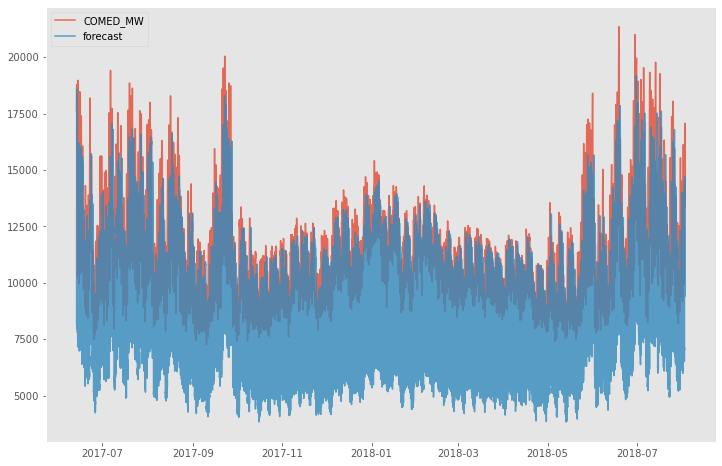

In [79]:
yhat = deep_learner.predict()
# Constructing the forecast dataframe
fc = comed_df.tail(len(yhat)).copy()
fc.reset_index(inplace=True)
fc['forecast'] = yhat
# Ploting the forecasts
plt.figure(figsize=(12, 8))
for dtype in ['COMED_MW', 'forecast']:
  plt.plot(
    'Datetime',
    dtype,
    data=fc,
    label=dtype,
    alpha=0.8
  )
plt.legend()
plt.grid()
plt.show()

In [80]:
# Creating the model using full data and forecasting n steps 
aheaddeep_learner = DeepModelTS(
    data = comed_df,
    Y_var = 'COMED_MW',
    lag = 48,
    LSTM_layer_depth = 64,
    epochs = 10,
    train_test_split = 0
)
# Fitting the model
deep_learner.LSTModel()
# Forecasting n steps ahead
n_ahead = 168
yhat = deep_learner.predict_n_ahead(n_ahead)
yhat = [y[0][0] for y in yhat]

Epoch 1/10
221/221 [==============================] - 10s 34ms/step - loss: 58384456.0000 - val_loss: 41125216.0000
Epoch 2/10
221/221 [==============================] - 7s 33ms/step - loss: 167837344.0000 - val_loss: 163937376.0000
Epoch 3/10
221/221 [==============================] - 7s 32ms/step - loss: 30083956.0000 - val_loss: 28006962.0000
Epoch 4/10
221/221 [==============================] - 7s 33ms/step - loss: 29972196.0000 - val_loss: 28208300.0000
Epoch 5/10
221/221 [==============================] - 8s 36ms/step - loss: 11306493.0000 - val_loss: 5788629.5000
Epoch 6/10
221/221 [==============================] - 8s 34ms/step - loss: 11035707.0000 - val_loss: 9065892.0000
Epoch 7/10
221/221 [==============================] - 8s 35ms/step - loss: 16417412.0000 - val_loss: 66091756.0000
Epoch 8/10
221/221 [==============================] - 7s 32ms/step - loss: 25000526.0000 - val_loss: 4922556.5000
Epoch 9/10
221/221 [==============================] - 9s 39ms/step - loss: 44444

312/312 [==============================] - 1s 5ms/step


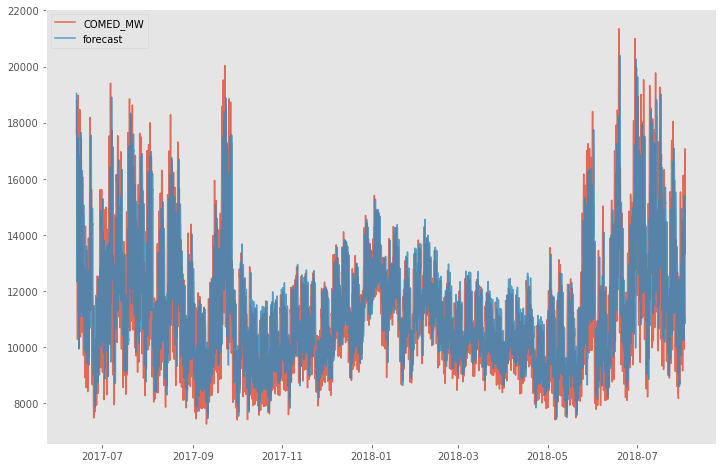

In [81]:
yhat = deep_learner.predict()
# Constructing the forecast dataframe
fc = comed_df.tail(len(yhat)).copy()
fc.reset_index(inplace=True)
fc['forecast'] = yhat
# Ploting the forecasts
plt.figure(figsize=(12, 8))
for dtype in ['COMED_MW', 'forecast']:
  plt.plot(
    'Datetime',
    dtype,
    data=fc,
    label=dtype,
    alpha=0.8
  )
plt.legend()
plt.grid()
plt.show()